In [1]:
## Generate training data
import os                   #operating system interface
import errno                #error symbols
import argparse             #command line input parsing

import numpy as np          #scientific computing (aka matlab)
import skimage.external.tifffile as tiff     #read/write TIFF files (aka our images)
import skimage.io
from tensorflow.python.keras.optimizers import SGD    #optimizer
from tensorflow.python.keras import backend as K            #tensorflow backend

from deepcell import get_image_sizes                #io_utils, returns shape of first image inside data_location
from deepcell import make_training_data             #data_utils, reads images in training directories and saves as npz file

from deepcell import bn_dense_feature_net
from deepcell import rate_scheduler                 #train_utils,
from deepcell import train_model_disc, train_model_conv, train_model_sample     #training.py, probably use sample
from deepcell import run_models_on_directory
from deepcell import export_model

# data options
DATA_OUTPUT_MODE = 'conv'
#DATA_OUTPUT_MODE = 'sample'
BORDER_MODE = 'valid' if DATA_OUTPUT_MODE == 'sample' else 'same'
RESIZE = True
RESHAPE_SIZE = 512

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'tissues/mibi/samir'
DATA_FILE = 'mibi_conv_{}_{}'.format(K.image_data_format(), DATA_OUTPUT_MODE)

for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
    except OSError as exc: # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def generate_training_data():
    file_name_save = os.path.join(NPZ_DIR, PREFIX, DATA_FILE)
    num_of_features = 2 # Specify the number of feature masks that are present
    window_size = (30, 30) # Size of window around pixel                
    training_direcs = ['set1', 'set2']
#    channel_names = ['dsDNA', 'Ca', 'H3K27me3', 'H3K9ac', 'Ta', 'edge_pred', 'interior_pred', 'bg_pred']
    channel_names = ['dsDNA', 'edge_pred', 'interior_pred', 'Ta']
#    channel_names = ['dsDNA']
    raw_image_direc = 'raw'
    annotation_direc = 'annotated'

    # Create the training data
    make_training_data(
        direc_name=os.path.join(DATA_DIR, PREFIX),
        dimensionality=2,
        max_training_examples=1e7, # Define maximum number of training examples
        window_size_x=window_size[0],
        window_size_y=window_size[1],
        border_mode=BORDER_MODE,
        file_name_save=file_name_save,
        training_direcs=training_direcs,
        channel_names=channel_names,
        num_of_features=num_of_features,
        raw_image_direc=raw_image_direc,
        annotation_direc=annotation_direc,
        reshape_size=RESHAPE_SIZE if RESIZE else None,
        edge_feature=[1, 0, 0], # Specify which feature is the edge feature,
        dilation_radius=1,
        output_mode=DATA_OUTPUT_MODE,
        display=False,
        verbose=True)


In [3]:
def train_model_on_training_data():
    direc_save = os.path.join(MODEL_DIR, PREFIX)
    direc_data = os.path.join(NPZ_DIR, PREFIX)
    training_data = np.load(os.path.join(direc_data, DATA_FILE + '.npz'))

    class_weights = training_data['class_weights']
    X, y = training_data['X'], training_data['y']
    print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

    n_epoch = 50
    batch_size = 32 if DATA_OUTPUT_MODE == 'sample' else 1
    optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    lr_sched = rate_scheduler(lr=0.01, decay=0.99)

    model_args = {
        'norm_method': 'median',
        'reg': 1e-5,
        'n_features': 3
    }

    data_format = K.image_data_format()
    row_axis = 2 if data_format == 'channels_first' else 1
    col_axis = 3 if data_format == 'channels_first' else 2
    channel_axis = 1 if data_format == 'channels_first' else 3

    if DATA_OUTPUT_MODE == 'sample':
        train_model = train_model_sample
        the_model = bn_feature_net_61x61                                #changed to 21x21
        model_args['n_channels'] = 1

    elif DATA_OUTPUT_MODE == 'conv' or DATA_OUTPUT_MODE == 'disc':
        train_model = train_model_conv
        the_model = bn_dense_feature_net
        model_args['location'] = False

        size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[row_axis:col_axis + 1]
        if data_format == 'channels_first':
            model_args['input_shape'] = (X.shape[channel_axis], size[0], size[1])
        else:
            model_args['input_shape'] = (size[0], size[1], X.shape[channel_axis])

    model = the_model(**model_args)

    train_model(
        model=model,
        dataset=DATA_FILE,
        optimizer=optimizer,
        batch_size=batch_size,
        n_epoch=n_epoch,
        direc_save=direc_save,
        direc_data=direc_data,
        lr_sched=lr_sched,
        class_weight=class_weights,
        rotation_range=180,
        flip=True,
        shear=False)


In [11]:
def run_model_on_dir():
    raw_dir = 'raw'
    data_location = os.path.join(DATA_DIR, PREFIX, 'set1', raw_dir)
    output_location = os.path.join(RESULTS_DIR, PREFIX)
    channel_names = ['dsDNA', 'edge_pred', 'interior_pred', 'Ta']
    
    image_size_x, image_size_y = get_image_sizes(data_location, channel_names)

#    model_name = '2018-06-28_mibi_61x61_{}_{}__0.h5'.format(
#        K.image_data_format(), DATA_OUTPUT_MODE)

    model_name = '2018-08-12_mibi_conv_channels_last_conv__0.h5'

    weights = os.path.join(MODEL_DIR, PREFIX, model_name)

    n_features = 3
    window_size = (30, 30)

    if DATA_OUTPUT_MODE == 'sample':
        model_fn = dilated_bn_feature_net_61x61                                 #changed to 21x21
    elif DATA_OUTPUT_MODE == 'conv':
        model_fn = bn_dense_feature_net
    else:
        raise ValueError('{} is not a valid training mode for 2D images (yet).'.format(
            DATA_OUTPUT_MODE))

    predictions = run_models_on_directory(
        data_location=data_location,
        channel_names=channel_names,
        output_location=output_location,
        n_features=n_features,
        model_fn=model_fn,
        list_of_weights=[weights],
        image_size_x=image_size_x,
        image_size_y=image_size_y,
        win_x=(0),
        win_y=(0),
        split=True)


In [5]:
generate_training_data()

Reshaped feature data from (2, 2048, 2048, 3) to (32, 512, 512, 3)
Reshaped training data from (2, 2048, 2048, 4) to (32, 512, 512, 4)
max_training_examples is: 10000000.0
list_of_max is: [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
list_of_max after mean-limiting is: [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
sample_label_matrix batch is:  [29 30 30 ... 29  4  7]
Number of features: 3
Number of training data points: 8388608
Class weights: [2.90824877 1.18492854 0.55181008]


In [ ]:
#just dsDNA
train_model_on_training_data()

In [6]:
# dsDNA, edge, interior
train_model_on_training_data()

X.shape: (32, 512, 512, 4)
y.shape: (32, 512, 512, 3)
X_train shape: (28, 512, 512, 4)
y_train shape: (28, 512, 512, 3)
X_test shape: (4, 512, 512, 4)
y_test shape: (4, 512, 512, 3)
Output Shape: (None, 512, 512, 3)
Number of Classes: 3
Using real-time data augmentation.
Epoch 1/50
27/28 [===========================>..] - ETA: 0s - loss: 0.6358 - acc: 0.7021
Epoch 00001: val_loss improved from inf to 1.92051, saving model to /data/models/tissues/mibi/samir/2018-08-12_mibi_conv_channels_last_conv__0.h5
28/28 [==============================] - 12s 442ms/step - loss: 0.6304 - acc: 0.7038 - val_loss: 1.9205 - val_acc: 0.7549
Epoch 2/50
27/28 [===========================>..] - ETA: 0s - loss: 0.4934 - acc: 0.7582
Epoch 00002: val_loss improved from 1.92051 to 1.33898, saving model to /data/models/tissues/mibi/samir/2018-08-12_mibi_conv_channels_last_conv__0.h5
28/28 [==============================] - 6s 205ms/step - loss: 0.4931 - acc: 0.7565 - val_loss: 1.3390 - val_acc: 0.7064
Epoch 3/50


Epoch 30/50
27/28 [===========================>..] - ETA: 0s - loss: 0.4102 - acc: 0.7626
Epoch 00030: val_loss improved from 0.93069 to 0.91274, saving model to /data/models/tissues/mibi/samir/2018-08-12_mibi_conv_channels_last_conv__0.h5
28/28 [==============================] - 6s 203ms/step - loss: 0.4099 - acc: 0.7623 - val_loss: 0.9127 - val_acc: 0.7689
Epoch 31/50
27/28 [===========================>..] - ETA: 0s - loss: 0.4100 - acc: 0.7646
Epoch 00031: val_loss did not improve
28/28 [==============================] - 6s 204ms/step - loss: 0.4105 - acc: 0.7635 - val_loss: 1.1590 - val_acc: 0.7099
Epoch 32/50
27/28 [===========================>..] - ETA: 0s - loss: 0.4071 - acc: 0.7610
Epoch 00032: val_loss did not improve
28/28 [==============================] - 6s 203ms/step - loss: 0.4059 - acc: 0.7612 - val_loss: 0.9903 - val_acc: 0.7514
Epoch 33/50
27/28 [===========================>..] - ETA: 0s - loss: 0.4022 - acc: 0.7568
Epoch 00033: val_loss did not improve
28/28 [======

In [12]:
run_model_on_dir()

input_3
image_normalization2d_3
conv2d_13
batch_normalization_17
activation_17
concatenate_13
conv2d_14
batch_normalization_18
activation_18
concatenate_14
conv2d_15
batch_normalization_19
activation_19
concatenate_15
conv2d_16
batch_normalization_20
activation_20
concatenate_16
conv2d_17
batch_normalization_21
activation_21
concatenate_17
conv2d_18
batch_normalization_22
activation_22
concatenate_18
tensor_prod2d_7
batch_normalization_23
activation_23
tensor_prod2d_8
batch_normalization_24
activation_24
tensor_prod2d_9
softmax_3
Processing image 1 of 1


/usr/local/lib/python3.5/dist-packages/deepcell/running.py:33: UserWarning: The split flag is deprecated and is designed to account for a maximum tensor size.
  warnings.warn('The split flag is deprecated and is designed to account '


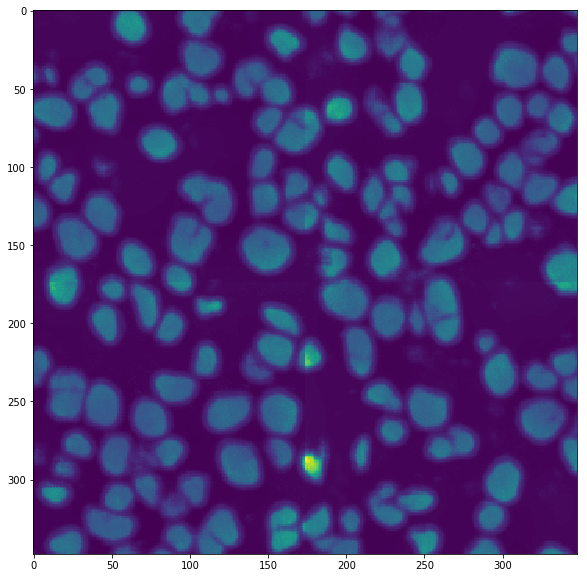

In [22]:
import matplotlib.pyplot as plt

index = 0

#fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
#ax = axes.ravel()


plt.rcParams['figure.figsize'] = [10,10]

winx1 = 850
winx2 = -850

winy1 = 1600
winy2 = -100

winy1 = 850
winy2 = -850

output = (skimage.io.imread('/data/results/tissues/mibi/samir/feature_1_frame_0.tif'))[winy1:winy2, winx1:winx2]
plt.imshow(output)

In [ ]:
output = (skimage.io.imread('/data/results/tissues/mibi/samir/feature_2_frame_0.tif'))[winy1:winy2, winx1:winx2]
plt.imshow(output)

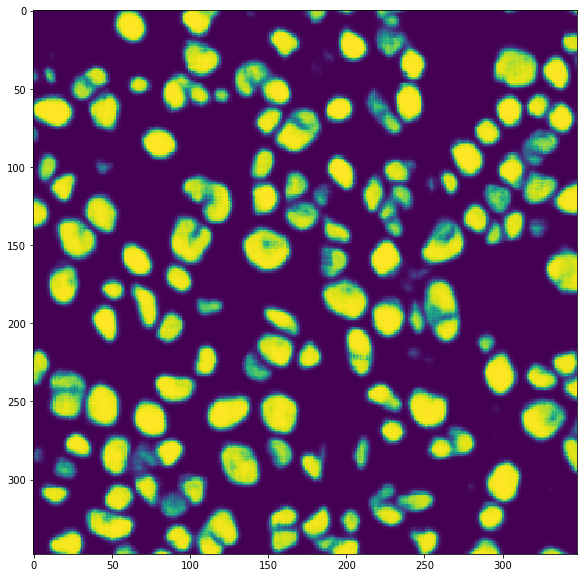

In [23]:

output = (skimage.io.imread('/data/data/tissues/mibi/samir/set1/raw/interior_pred.tif'))[winy1:winy2, winx1:winx2]
plt.imshow(output)

In [26]:
vim = [1]
print(len(vim))

1
